<h1>Demand prediction with Time Series</h1>

[0. Overview of the dataset](#overview)<br>
[1. EDA](#EDA)<br>
[2. Decomposition of the time series](#decomposition)<br>
[3. ARIMA](#ARIMA)<br>

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import datetime as dt



<a id='#overview'></a>


<h2>Overview of the dataset</h2>

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head(2)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11


In [4]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [5]:
train.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

Number of samples in test and train

In [6]:
print('Number of samples in test : ',train.shape[0],'\n''Number of samples in train : ',test.shape[0])

Number of samples in test :  913000 
Number of samples in train :  45000


In [7]:
print('Number of stores : ',len(train.store.unique()),'\n''Nnumber of items :',len(train.item.unique()) )

Number of stores :  10 
Nnumber of items : 50


In [8]:
train.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

<a id='EDA'></a>

<h2>EDA Sales and Time</h2>

<b>Total sales per item</b>

In [9]:
item_sales=train.groupby(['item'])['sales'].sum()

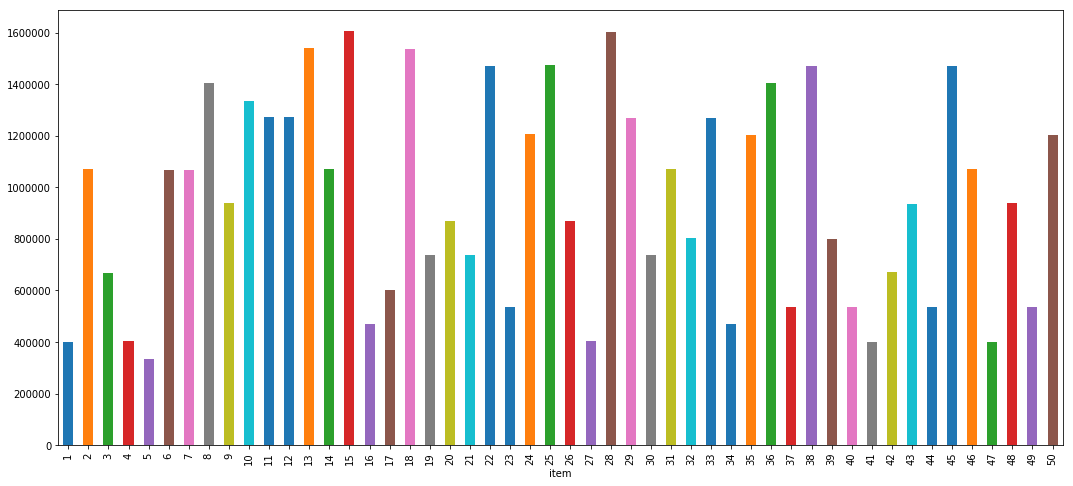

In [10]:
item_sales.plot(kind = 'bar',figsize=(18,8))

In [11]:
print ('less sold item : ',item_sales.min(),' most sold item : ',item_sales.max())

less sold item :  335230  most sold item :  1607442


<b>Total sales per store</b>

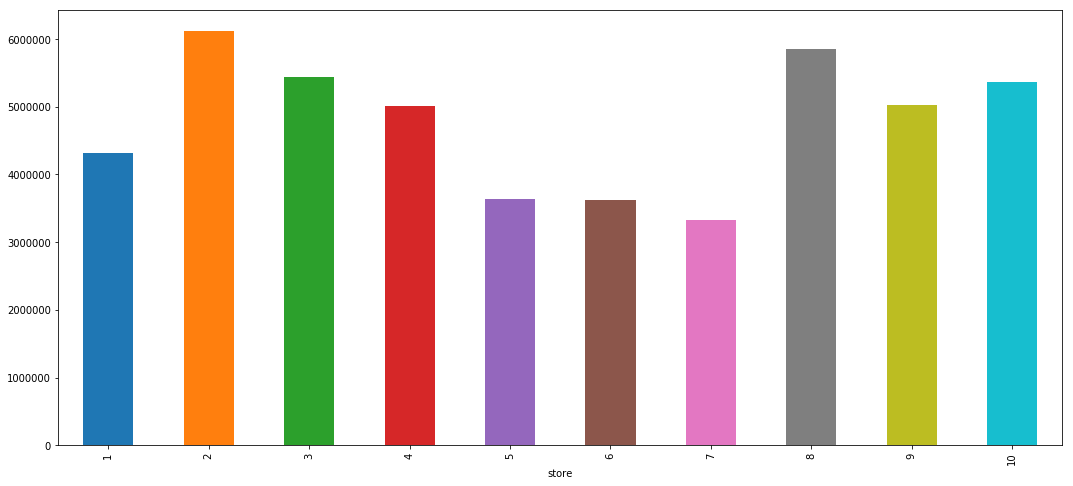

In [12]:
store_sales=train.groupby(['store'])['sales'].sum()
store_sales.plot(kind = 'bar',figsize=(18,8))

<b>Sales and Time<b>

TimeSeries by product / Do the products show different patterns in time

<center><h3>Timeseries per store</h3></center>


Visualize the distribuition of the sum of all products and all stores

In [14]:
sales_stores = train.groupby(['store','date'])['sales'].sum()

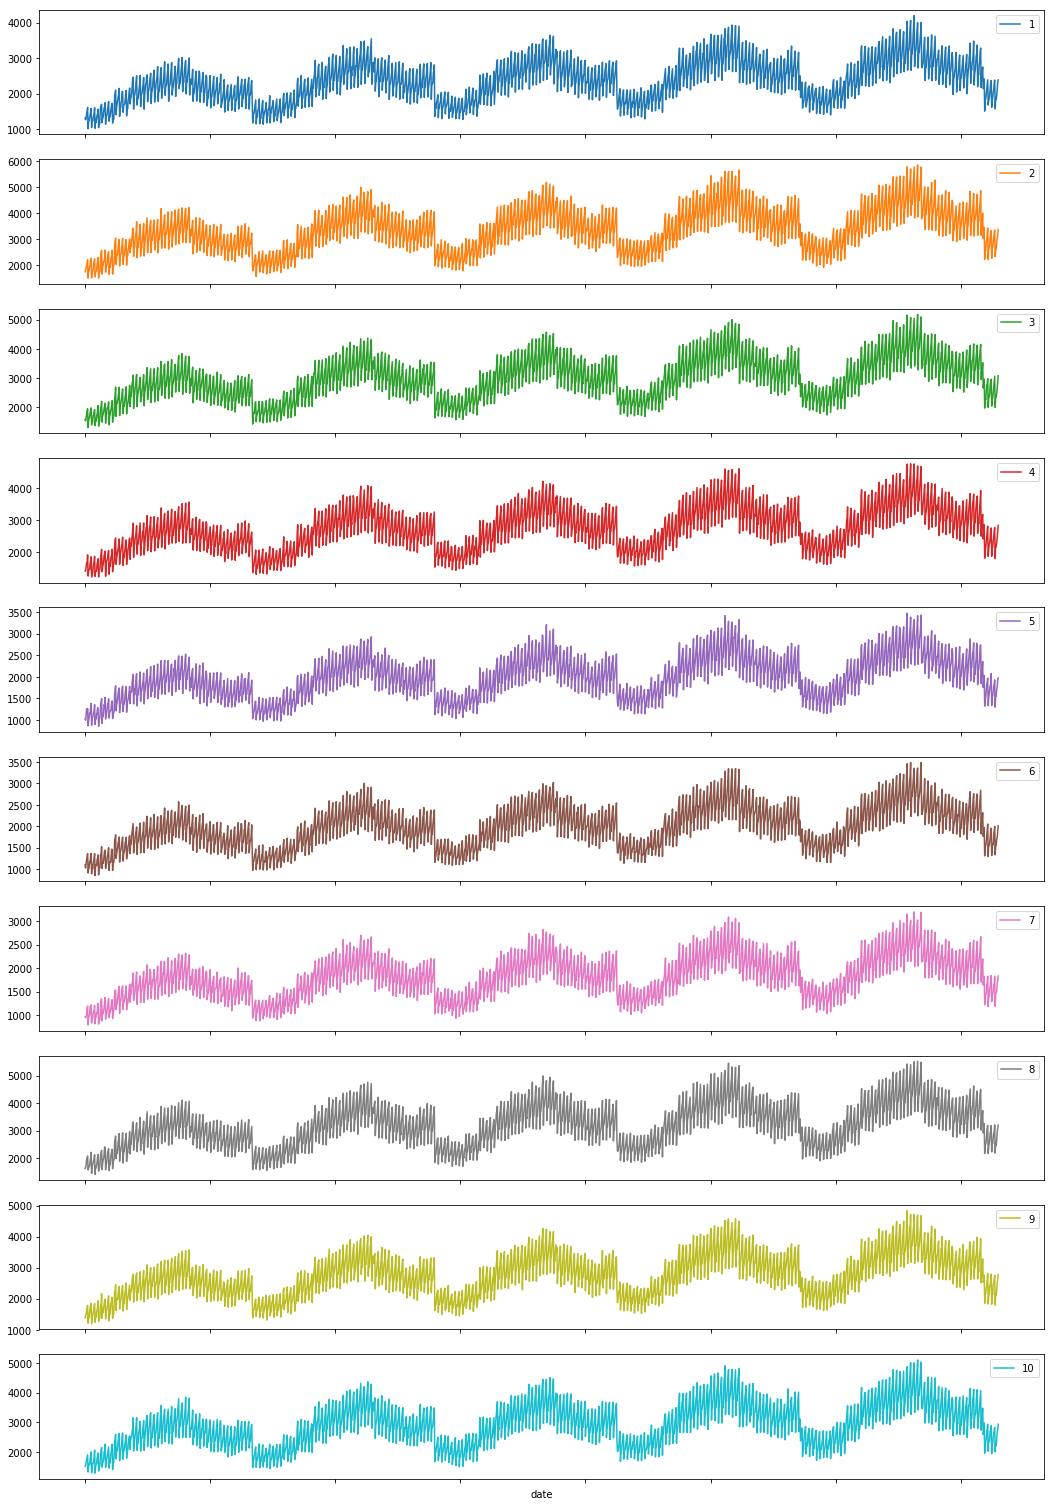

In [21]:
sales_stores.unstack(level=0).plot(kind='line',figsize=(18,30),subplots=True)
plt.show()

<center><h3>Timeseries by product</h3></center>

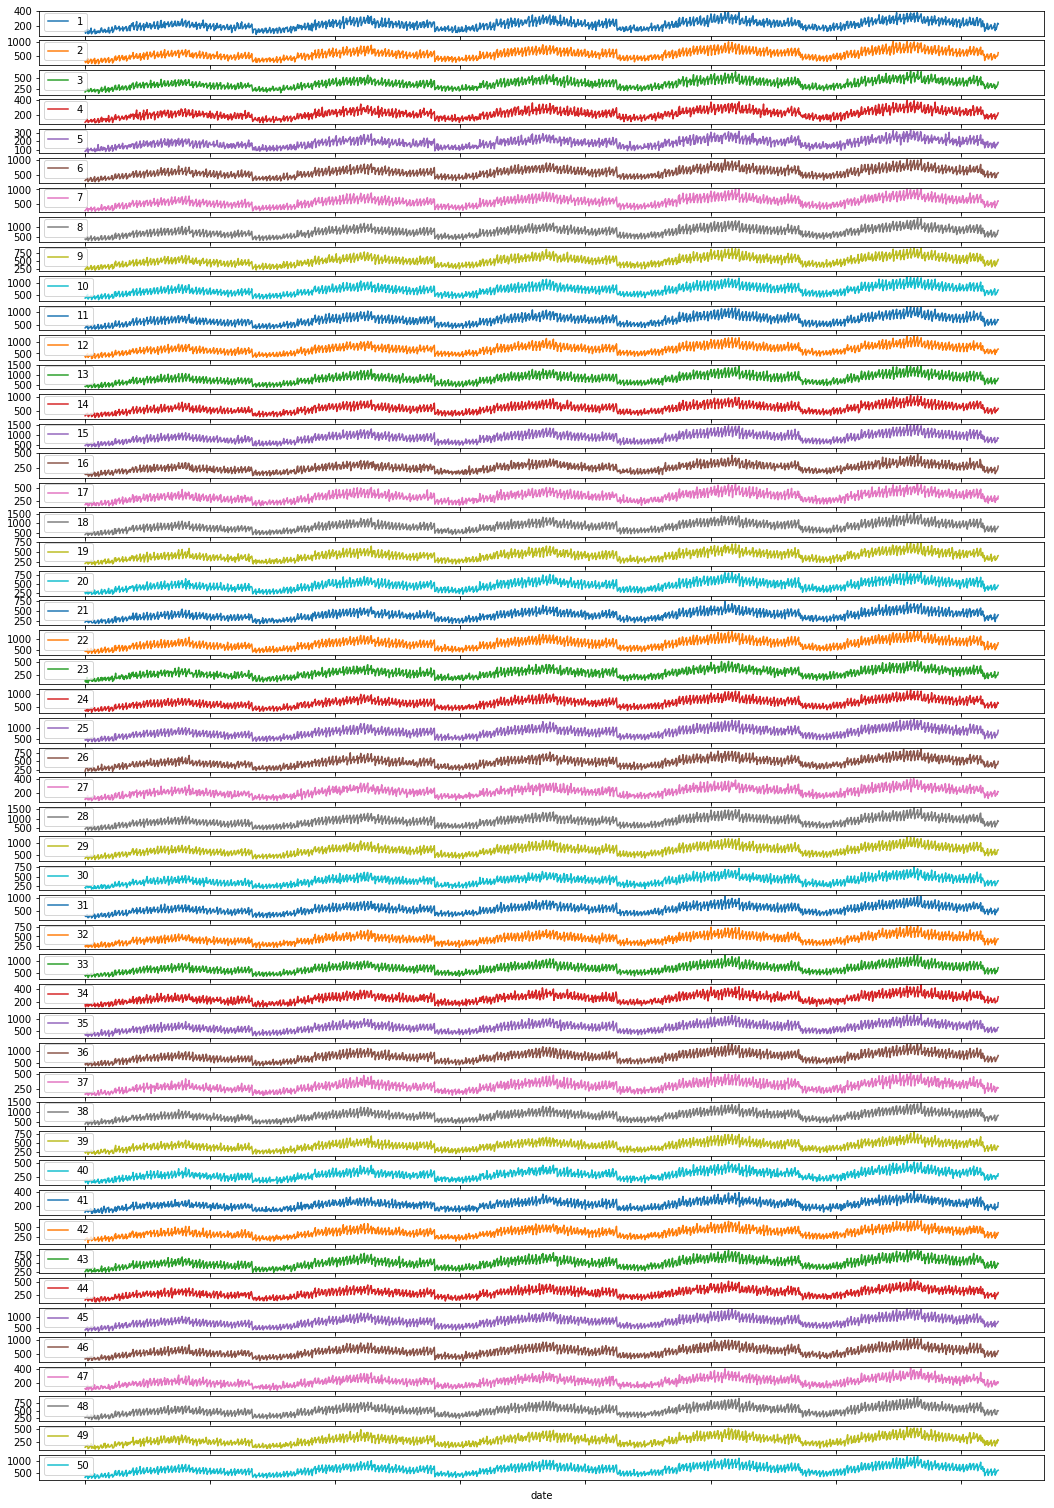

In [23]:
sales_items = train.groupby(['item','date'])['sales'].sum()
sales_items.unstack(level=0).plot(kind='line',figsize=(18,30),subplots=True)
plt.show()

<a id='decomposition'></a>


<h2>Decomposition of the time series</h2>

<Figure size 432x288 with 0 Axes>

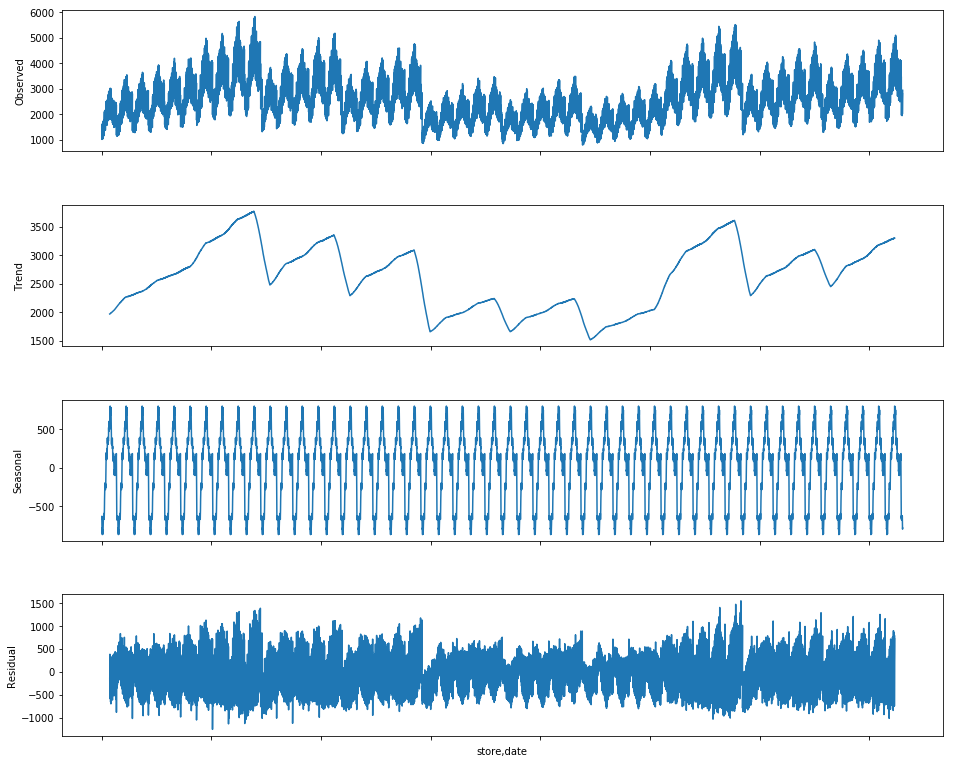

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(sales_stores, model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

To get more information about the stationarity of the time series is stationary I will use a visual rolling window approach and a corresponding Dickey Fuller Test
In order to reduce computiona time I will use a random shop/randome item analisis.

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [32]:
train.set_index('date',inplace=True)

In [46]:
partial_train = train[(train['store']==5) & (train['item']==5)]

<b>Visualizing rolling mean and and rolling STD</b>

In [47]:
from statsmodels.tsa.stattools import adfuller

def visualize_stationarity(data, window = 12, cutoff = 0.01):

    
    fig = plt.figure(figsize=(16, 8))
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(data.rolling(window).mean(), color='red', label='RMean')
    std = plt.plot(data.rolling(window).std(), color='green', label = 'Standard Deviation')
    plt.legend()
    plt.title('Visualization of rolling mean and standard deviation')
    plt.show()
    
    
  

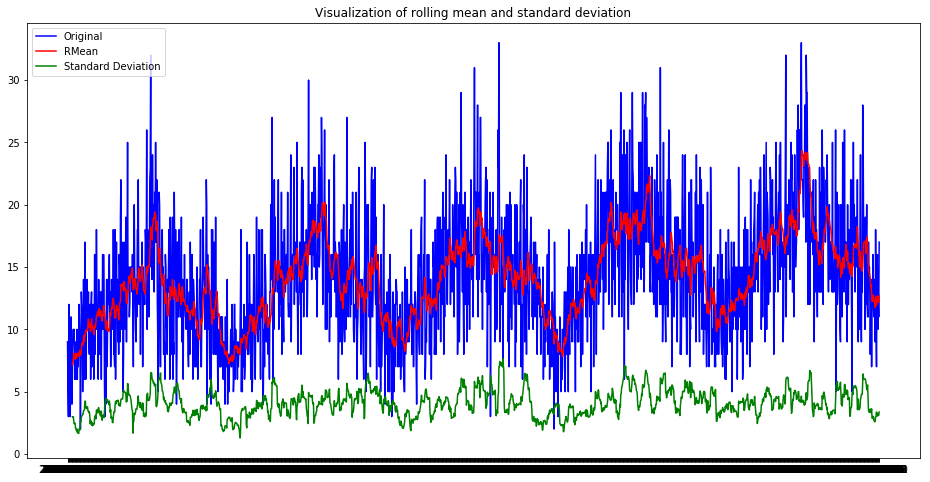

In [48]:
#visualize_stationarity(train.sales)
visualize_stationarity(partial_train['sales'])

<b>Dickey-Fuller Test<b>

In [56]:
X = partial_train['sales'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.415736
p-value: 0.010434
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


<b>Modyfing the timeseries with lag 1 to see the autocorrelatation between observations in time</b>

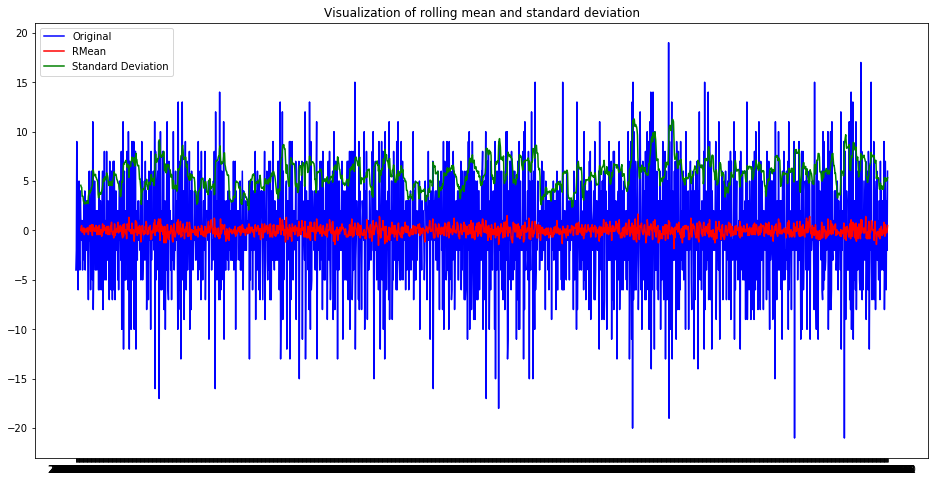

In [58]:
first_diff = partial_train.sales - partial_train.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
visualize_stationarity(first_diff, window = 12)

In [59]:
X = first_diff.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.606796
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Getting the Auto Corelation Function and the Partial Auto Corelation Function

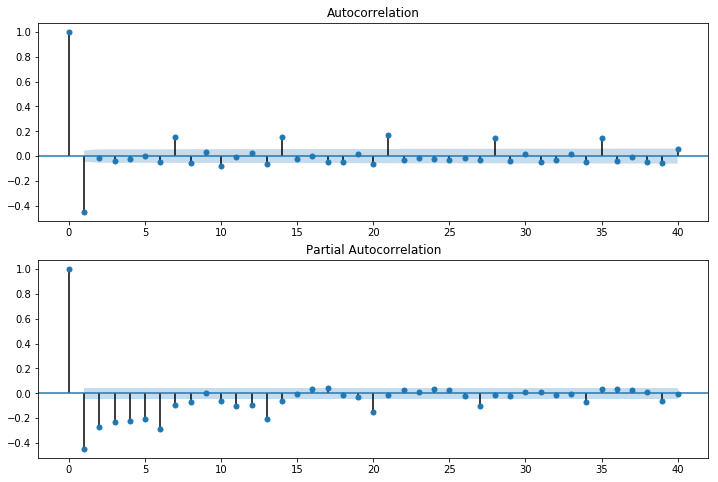

In [60]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

<a id='ARIMA'></a>

<h2>ARIMA modell</h2>

p indicating the periods used for autoregression. 
d is the number of nonseasonal differences needed for stationarity
q is the number of lagged forecast errors in the prediction equation.

In [61]:
arima_mod6_1_0 = sm.tsa.ARIMA(train.sales, (6,1,0)).fit(disp=False)
print(arima_mod6_1_0.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:               912999
Model:                 ARIMA(6, 1, 0)   Log Likelihood            -3358464.248
Method:                       css-mle   S.D. of innovations              9.579
Date:                Sun, 25 Aug 2019   AIC                        6716944.496
Time:                        18:01:54   BIC                        6717038.291
Sample:                             1   HQIC                       6716970.402
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.657e-05      0.002      0.029      0.977      -0.004       0.004
ar.L1.D.sales    -0.8354      0.001   -949.482      0.000      -0.837      -0.834
ar.L2.D.sales    -0.7486      0.001   -7